In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
from scipy.interpolate import interp1d
from scipy import integrate
from scipy.integrate import odeint

In [121]:
def rocket_lab_program():
    
    START_THRESHOLD = 0.04
    STOP_THRESHOLD = 0.04
    NEWTONS_PER_POUND = 10
    NEWTONS_PER_GRAM = 101.97162
    file_name_end = (input("File in Log Rocket Data?: "))
    propellant_mass_g = float(input("Propellant Mass (g)?: "))
    dry_mass_g = float(input("Dry Mass (g)?: "))
    total_mass_g = float(propellant_mass_g + dry_mass_g)
    Cd= float(input("Cd?: "))
    A= float(input("Crossectional Area?: "))
    rho= float(input("Air Density?: "))
    propellant_mass = 0.001 * propellant_mass_g
    dry_mass= 0.001 * dry_mass_g
    total_mass = 0.001 * total_mass_g
    
    MOTOR_CLASSES = [
    ('1/8A',0),
    ('1/4A',0.3126),
    ('1/2A',0.626),
    ('A',1.26),
    ('B',2.52),
    ('C',5.02),
    ('D',10.01),
    ('E',20.02),
    ('F',40.02),
    ('G',80.02),
    ('H',160.02),
    ('I',320.01),
    ('J',640.01),
    ('K',1280.01),
    ('L',2560.01),
    ('M',5120.01),
    ('N',20480.01),
    ('O',40960.01)
    ]


    start_time = None
    max_thrust = 0.0
    total_impulse = 0.0
    motor_class = ""
    file_name_full = "/Users/augustzentner/Downloads/RocketTestStand-main/Log Rocket Data/" + file_name_end
    with open(file_name_full) as f:
        lines = f.read().split()
        #print('lines = ',lines)
        #print('  > The start_time is ',start_time)
        data = []
        for line in lines:
            #print(' The line is ',line)
            x,y = line.split(',')
            x,y = float(x),float(y)
            #print('       x = ',x)
            y = y / NEWTONS_PER_POUND
            #print('       y = ',y)
            if (y > START_THRESHOLD) and (start_time is None):
                start_time = x
                #print(' Start time assigned to ',start_time)
            if (y < STOP_THRESHOLD) and (start_time is not None):
                break
            if start_time is not None:
                xvalue=x-start_time
                data.append([xvalue,y])
                #print('Appending data right now')
                try:
                    total_impulse += y * (xvalue-data[-2][0])
                except:
                    pass
                if y > max_thrust:
                    max_thrust = y

    for val in MOTOR_CLASSES:
        c,imp = val
    
        if total_impulse > imp:
            motor_class = c
        
    x_lst = [d[0] for d in data]
    y_lst = [d[1] for d in data]
    
    initial_t = min(x_lst)
    final_t = max(x_lst)
    dt = 0.01
    #t_thrust = t_range_thrust(initial_t,final_t,delta_t)
    t_thrust = x_lst
    x_interp = np.arange(initial_t, final_t, dt)
    
    Impulse_per_Gram = total_impulse / propellant_mass

    #print('The value of x_lst is ',x_lst)


    return (x_lst, y_lst, propellant_mass, dry_mass, total_mass, initial_t, final_t, t_thrust, x_interp, dt,
            propellant_mass_g, dry_mass_g, total_mass_g, Cd, A, rho, max_thrust, total_impulse, Impulse_per_Gram, motor_class)

In [122]:
def interp_func_th_program(x_lst,y_lst):
    
    interp_func_th = interp1d(x_lst, y_lst)
    return interp_func_th

In [123]:
def get_mass_derivative_constant(interp_func_th,t_initial,t_final,dry_mass,total_mass):
    '''
    Get the constant in the mass derivative.
    '''
    
    n_step_max=5000
    
    [total_impulse_2,impulse_error] = integrate.quad(interp_func_th,t_initial,t_final,limit=n_step_max)
    mass_derivative_constant = (1.0/(dry_mass - total_mass)) * total_impulse_2
    
    return mass_derivative_constant

In [124]:
def mass_derivative(interp_func_th, mass_derivative_constant, x_lst):
    
    dmdt = interp_func_th(x_lst)/mass_derivative_constant
    return dmdt

In [125]:
def mass_func_program(mass_derivative, t_initial, x_lst,total_mass, interp_func_th):

    mass_list=np.array([])

    for t in x_lst:
    
        [impulse,error] = integrate.quad(interp_func_th, initial_t, t,limit=500)
    
        mass = 1.0*impulse/mass_derivative_constant + total_mass
    
        mass_list=np.append(mass_list, mass)
    
    mass_function=interp1d(t_thrust, mass_list, 'cubic')
    
    return mass_function, mass_list

In [126]:
def drag_force(v, Cd, rho, A):
    
    fd=0.5*Cd*rho*A*(v**2)
    
    return fd

In [127]:
def dvdt_program(v, t, interp_func_th, mass_function, mass_derivative_constant, dry_mass, final_t, Cd ,rho ,A):
    
    gravity = 9.8067    # in m/s^2
    
    if ( t>final_t): 
        # only gravity and drag
        mass=0.001 * dry_mass
        fg = 1.0*gravity # this is the force of gravity
        # the drag force need to always be in the opposite direction of motion
        fd = drag_force(v, Cd, rho, A)/mass
        if ( v < 0.0 ):
            fd=-1.0*fd
        derivative = -fg -fd
        return derivative
    
    else:
        mass = mass_function(t) # this gives the instantaneous mass
    
        fth = interp_func_th(t)/mass # this is the thrust/mass
    
        dmdt = fth/mass_derivative_constant # this is dm/dt
    
        fdm = v*dmdt/mass # this is the extra piece for the changing mass
    
        fg = 1.0*gravity # this is the force of gravity
    
        # the drag force need to always be in the opposite direction of motion
        fd = drag_force(v, Cd, rho, A)/mass
        if ( v < 0.0 ):
            fd=-1.0*fd
        
        dvdt = fth - fg - fd - fdm
    
        return dvdt

In [128]:
def speed_program( x_lst, interp_func_th, mass_function, mass_derivative_constant, dry_mass, final_t, Cd ,rho ,A):

    args=(interp_func_th, mass_function, mass_derivative_constant, dry_mass, final_t, Cd ,rho ,A)

    speed = odeint(dvdt_program,0.0,x_lst,args)

    speed_list=speed[:,0]

    idx=np.where(speed_list>0.0)

    for ii in range(idx[0][0]):
        speed_list[ii]=0.0
        
    speed_function = interp1d(x_lst,speed_list,'cubic')
    
    return speed_list, speed_function, idx

In [129]:
def height_program(x_lst, speed_function, speed_list, initial_t):
    height=np.array([])
    for t in x_lst:
        [h,err]=integrate.quad(speed_function,initial_t,t)
        height=np.append(height,h)
    height_function = interp1d(x_lst,speed_list)
    return height_function, height

In [130]:
def thrust_graph(x_lst, y_lst, max_thrust, propellant_mass, total_impulse, Impulse_per_Gram, motor_class, intial_t, final_t):
      
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(x_lst,y_lst)
    plt.title("Thrust Curve")
    plt.ylabel("Thrust (Newtons)")
    plt.xlabel("Time (seconds)")        
    plt.grid(which='major', axis='both')
    #plt.xlim(0,x_lst[-1])
    plt.ylim(0,ceil(max_thrust))
    text_str = "Propellant Mass: %.f g" % propellant_mass
    text_str += "\nBurn Time: %.2f s" % x_lst[-1]
    text_str += "\nMax Thrust: %.2f N" % max_thrust
    text_str += "\nTotal Impulse: %.2f N%ss" % (total_impulse, u"\u00B7")
    text_str += "\nImpulse per gram: %.2f (N%ss)/g" % (Impulse_per_Gram, u"\u00b7")
    text_str += "\nMotor Class: %s" % motor_class
    plt.text(0.75, 0.97, text_str, transform=ax.transAxes,
        verticalalignment='top', bbox=dict(facecolor='white'))
    plt.show()

In [131]:
def mass_derivative_graph(dmdt, x_lst, x_interp):
    min_mass_derivative = np.min(dmdt)
    max_mass_derivative = np.max(dmdt)

    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(x_lst, 0.001 * dmdt)
    plt.title("Mass Derivative")
    plt.ylabel("dm/dt [g/s]")
    plt.xlabel("Time [seconds]")        
    plt.grid(which='major', axis='both')
    #plt.xlim(0,x_lst[-1])
    plt.show()
    
    return

In [132]:
def mass_graph(mass_function, x_lst, intial_t, final_t, dry_mass, total_mass):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(x_lst,mass_function(x_lst))
    plt.title("Mass vs. Time")
    plt.ylabel("mass [g]")
    plt.xlabel("Time [s]")        
    plt.grid(which='major', axis='both')
    plt.show()

In [133]:
def velocity_graph(speed_function, x_lst, x_interp, intial_t, final_t):
    v_interpolated=speed_function(x_interp)

    fig=plt.figure(figsize=(10,10))

    plt.plot(x_lst,speed_list,linewidth=2.0,color='darkolivegreen')
    plt.plot(x_interp,v_interpolated,linewidth=1.0,color='firebrick')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    #plt.xlim(0.0,10.0)
    #plt.ylim(0.0,2.5)

    plt.xlabel(r"$t$",fontsize=15)
    plt.ylabel(r"$v(t)$",fontsize=15)
    #plt.figure(figsize=(20,20))
    fig.set_facecolor("white")

    plt.show

In [134]:
def height_graph(height, x_lst, x_interp, intial_t, final_t):
    fig=plt.figure(figsize=(10,10))

    plt.plot(x_lst,height,linewidth=2.0,color='darkolivegreen')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    #plt.xlim(0.0,10.0)
    #plt.ylim(0.0,2.5)

    plt.xlabel(r"$t$",fontsize=15)
    plt.ylabel(r"$h(t)$",fontsize=15)
    #plt.figure(figsize=(20,20))
    fig.set_facecolor("white")

    plt.show

File in Log Rocket Data?:  39mmRocket1.txt
Propellant Mass (g)?:  1
Dry Mass (g)?:  1
Cd?:  1
Crossectional Area?:  1
Air Density?:  1


/var/folders/g8/c0l7tdf94tn0kxy2sv51ghmc0000gn/T/ipykernel_32339/1934213872.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  [total_impulse_2,impulse_error] = integrate.quad(interp_func_th,t_initial,t_final,limit=n_step_max)
/var/folders/g8/c0l7tdf94tn0kxy2sv51ghmc0000gn/T/ipykernel_32339/412937894.py:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  [impulse,error] = integrate.quad(interp_func_th, initial_t, t,limit=500)
/var/folders/g8/c0l7tdf94tn0kxy2sv51ghmc0000gn/T/ipykernel_32339/2313343767.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local diffic

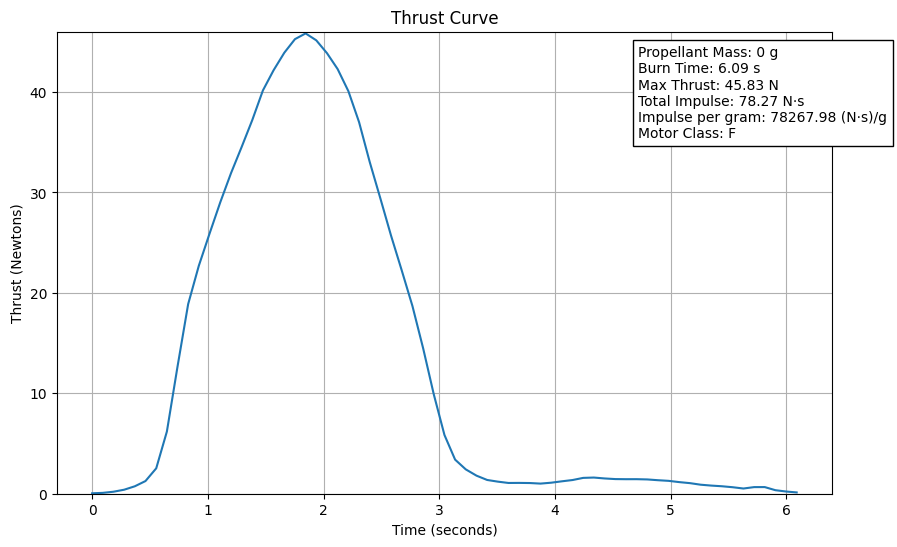

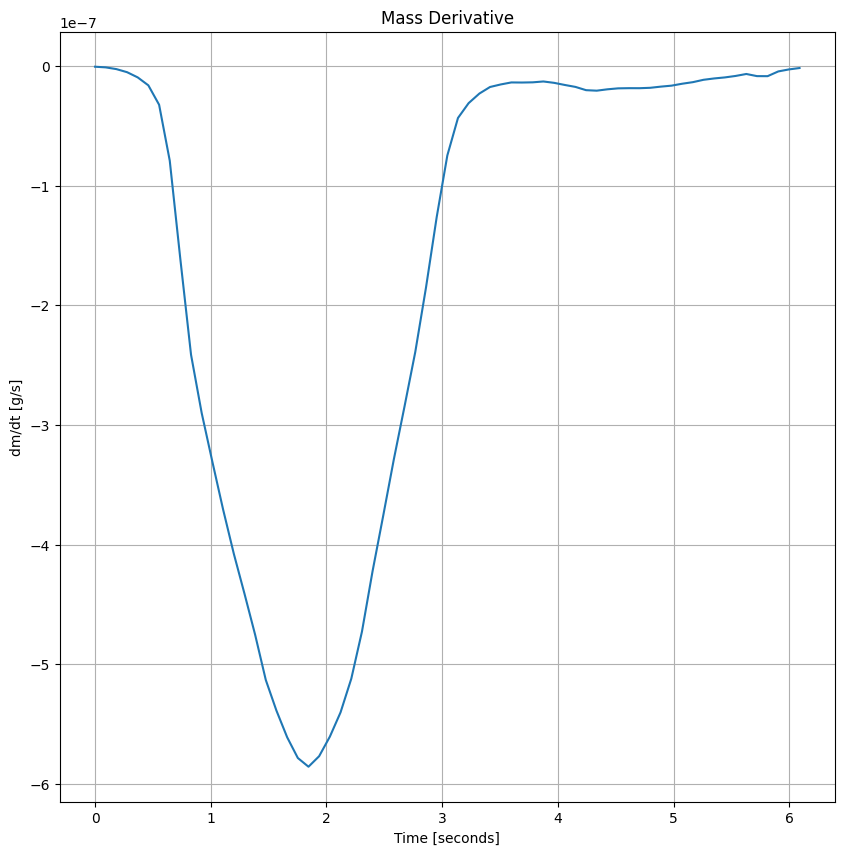

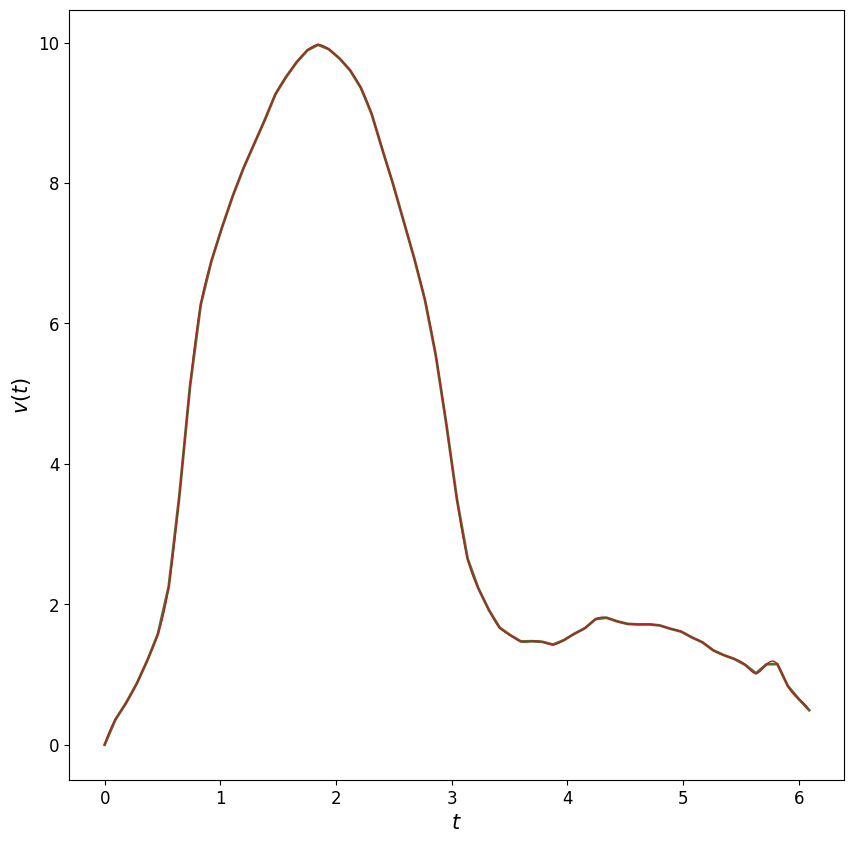

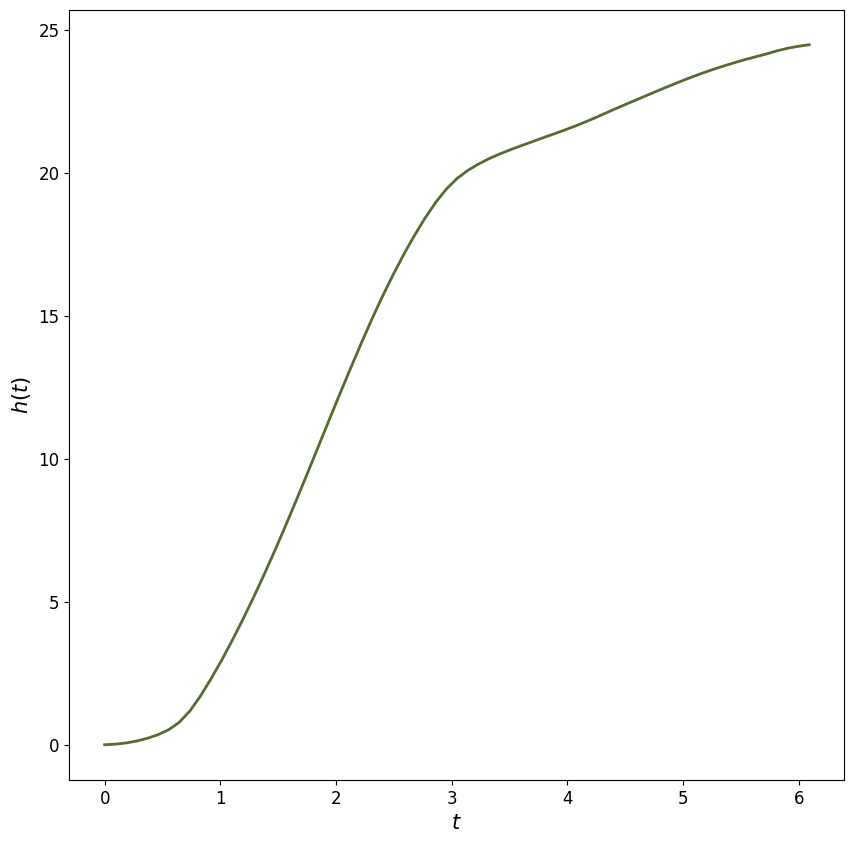

In [135]:
[x_lst, y_lst, propellant_mass, dry_mass, total_mass, initial_t, final_t, t_thrust, x_interp, dt, propellant_mass_g, dry_mass_g, total_mass_g, Cd, A, rho, max_thrust, total_impulse, Impulse_per_Gram, motor_class] = rocket_lab_program()

interp_func_th = interp_func_th_program(x_lst,y_lst)

mass_derivative_constant = get_mass_derivative_constant(interp_func_th,initial_t,final_t,dry_mass,total_mass)

dmdt = mass_derivative(interp_func_th, mass_derivative_constant, x_lst)

[mass_function, mass_list] = mass_func_program(mass_derivative, initial_t, x_lst,total_mass, interp_func_th)

[speed_list, speed_function, idx] = speed_program(x_lst, interp_func_th, mass_function, mass_derivative_constant, dry_mass, final_t, Cd ,rho ,A)

[height_function, height] = height_program(x_lst, speed_function, speed_list, initial_t)

thrust_graph(x_lst, y_lst, max_thrust, propellant_mass, total_impulse, Impulse_per_Gram, motor_class, initial_t, final_t)

mass_derivative_graph(dmdt, x_lst, x_interp)

velocity_graph(speed_function, x_lst, x_interp, initial_t, final_t)

height_graph(height, x_lst, x_interp, initial_t, final_t)